# ImageNet classification
This notebook shows an example of ImageNet classification 
The network that is used for inference is a variant of DoReFaNet, whose topology is illustrated in the following picture.
The pink layers are executed in the Programmable Logic at reduced precision (1 bit for weights, 2 bit for activations) while the other layers are executed in python.

This notebook shows how to classify an image choosen by the user, while [dorefanet-imagenet-samples](./dorefanet-imagenet-samples.ipynb) runs the classification on labeled images (extracted from the dataset)

![DoReFaNet topology](dorefanet-topology.svg)

In [1]:
import os, pickle, random
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

import numpy as np
import cv2

import qnn
from qnn import Dorefanet
from qnn import utils

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device, allocate memory buffers and load the network hyperparameters and weights. 
The neural network to be implemented is specified in a json file (*dorefanet-layers.json* in this example)
The weights for the non-offloaded layers are also loaded in a numpy dictionary to be used for execution in python. 

In [2]:
classifier = Dorefanet()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-conv0.npy', encoding="latin1", allow_pickle=True).item()
fc_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-fc-normalized.npy', encoding='latin1', allow_pickle=True).item()

## 2. Get ImageNet Classes information
Load labels and *synsets* of the 1000 [ImageNet](www.image-net.org/) classes into dictionaries

In [3]:
with open("/home/xilinx/jupyter_notebooks/qnn/imagenet-classes.pkl", 'rb') as f:
    classes = pickle.load(f)
    names = dict((k, classes[k][1].split(',')[0]) for k in classes.keys())
    synsets = dict((classes[k][0], classes[k][1].split(',')[0]) for k in classes.keys())

## 3. Open image to be classified
The image to be run through object classification is loaded automatically from the path set in the *img_folder* variable. The original image is shown before processing and will be automatically selected as the last one downloaded (both variables *img_folder* and *image_name* can be modified to the desired path/image to be classified). 

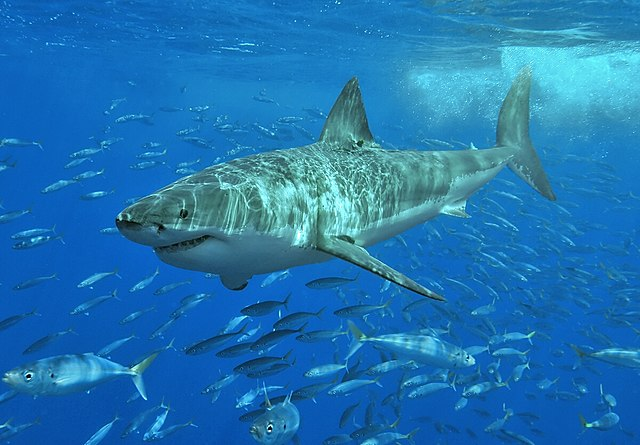

In [4]:
img_folder = "/home/xilinx/jupyter_notebooks/qnn/images/"

img_file = os.path.join(img_folder, max(os.listdir(img_folder), key=lambda f: os.path.getctime(os.path.join(img_folder, f))))
img, img_class = classifier.load_image(img_file)
im = Image.open(img_file)
im

## 4. Execute the first convolutional layer in Python
The first layer of this neural network has not been quantized, thus will not be executed in the HW accelerator (which supports only quantized arithmetic). 
Python provides, with numpy, a backend to execute convolution and other matrix operations. For user convenience the most popular operations (convolutional layer, thresholding, relu and fully connected layer) are provided in the class.

In [5]:
conv0_W = conv0_weights['conv0/W']
conv0_T = conv0_weights['conv0/T']

start = datetime.now()
# 1st convolutional layer execution, having as input the image and the trained parameters (weights)
conv0 = utils.conv_layer(img, conv0_W, stride=4)
# The result in then quantized to 2 bits representation for the subsequent HW offload
conv0 = utils.threshold(conv0, conv0_T)

# Allocate accelerator output buffer
end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("First layer SW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'w'))

First layer SW implementation took 738345 microseconds


## 5. HW Offload of the quantized layers
The core layers, which values have been quantized during training, are executed in the Programmable Logic. The hardware accelerator consists of a dataflow implementation of multiple layers (in this case, convolution+maxpool). 
The host code parses the network topology (specified in the json file) and manages the sequence of execution on the accelerator.

In [6]:
# Compute offloaded convolutional layers
out_dim = net['merge4']['output_dim']
out_ch = net['merge4']['output_channels']

conv_output = classifier.get_accel_buffer(out_ch, out_dim);
conv_input = classifier.prepare_buffer(conv0)

start = datetime.now()
classifier.inference(conv_input, conv_output)
end = datetime.now()

micros = int((end - start).total_seconds() * 1000000)
print("HW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

conv_output = classifier.postprocess_buffer(conv_output)

HW implementation took 233051 microseconds


## 6. Fully connected layers in python
The fully connected layers, are executed in the python backend and the classification finalized

In [7]:
# Normalize results
fc_input = conv_output / np.max(conv_output)

start = datetime.now()

# FC Layer 0
fc0_W = fc_weights['fc0/Wn']
fc0_b = fc_weights['fc0/bn']

fc0_out = utils.fully_connected(fc_input, fc0_W, fc0_b)
fc0_out = utils.qrelu(fc0_out)
fc0_out = utils.quantize(fc0_out, 2)

# FC Layer 1
fc1_W = fc_weights['fc1/Wn']
fc1_b = fc_weights['fc1/bn']

fc1_out = utils.fully_connected(fc0_out, fc1_W, fc1_b)
fc1_out = utils.qrelu(fc1_out)

# FC Layer 2
fct_W = fc_weights['fct/W']
fct_b = np.zeros((fct_W.shape[1], ))

fct_out = utils.fully_connected(fc1_out, fct_W, fct_b)
end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("Fully-connected layers took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

Fully-connected layers took 2112228 microseconds


## 7. Classification Results
The top-5 results of the inference are provided with the corresponding human readable labels.
The final classification scores are computed by a SoftMax Operator, that gives the normalized probabilities for all the classes.

class:   great white shark	probability:  79.40%
class:         tiger shark	probability:  18.92%
class:          hammerhead	probability:   1.63%
class:            sturgeon	probability:   0.01%
class:            stingray	probability:   0.01%


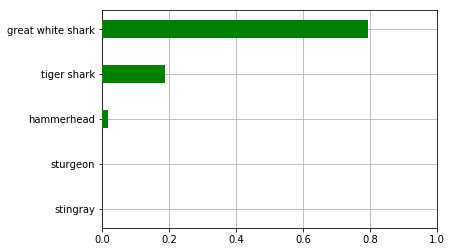

In [8]:
# Softmax
out = utils.softmax(fct_out)

# Top-5 results
topn =  utils.get_topn_indexes(out, 5)  
for k in topn: print("class:{0:>20}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
        
x_pos = np.arange(len(topn))
plt.barh(x_pos, out[topn], height=0.4, color='g', zorder=3)
plt.yticks(x_pos, [names[k] for k in topn])
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.grid(zorder=0)
plt.show()

## 8. Performance evaluation
This part show the performance of both software and hardware execution in terms of execution time, number of operations and number of operations over time.
The software execution includes the first convolutional layer and the fully connected layers, while the hardware execution includes all the offloaded convolutional layers

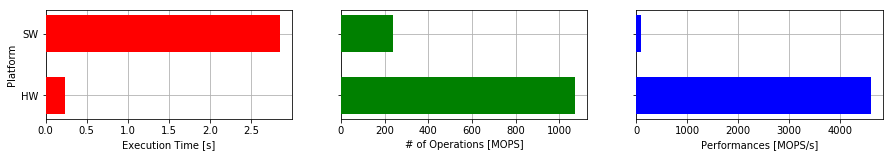

In [9]:
array = np.loadtxt('timestamp.txt')
array = list(map(lambda x: x/1000000, array))

MOPS   = [238.176256, 1073.856969]
TIME   = [array[0] + array[2], array[1]]
MOPSS  = [m / t for (m, t) in zip(MOPS ,TIME)]
LABELS = ['SW', 'HW']

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME, height=0.6, color='r', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time [s]")
ax1.set_ylabel("Platform")
ax1.grid(zorder=0)

ax2.barh(x_pos, MOPS, height=0.6, color='g', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("# of Operations [MOPS]")
ax2.grid(zorder=0)

ax3.barh(x_pos, MOPSS, height=0.6, color='b', zorder=3)
ax3.invert_yaxis()
ax3.set_xlabel("Performances [MOPS/s]")
ax3.grid(zorder=0)

plt.show() 

## 9. SW execution of the quantized layers
The core layers, which values have been quantized during training, are now executed in SW (by executing the HLS C++ source code).
The host code parses the network topology (specified in the json file) and manages the sequence of execution on the accelerator.

In [10]:
classifier_sw = Dorefanet("python_sw")
classifier_sw.init_accelerator()
conv_output_sw = classifier_sw.get_accel_buffer(out_ch, out_dim);
start = datetime.now()
classifier_sw.inference(conv_input, conv_output_sw)
end = datetime.now()

micros = int((end - start).total_seconds() * 1000000)
print("HW implementation took {} microseconds".format(micros))

HW implementation took 397576863 microseconds


## Reset the device

In [11]:
classifier.deinit_accelerator()


In [12]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()

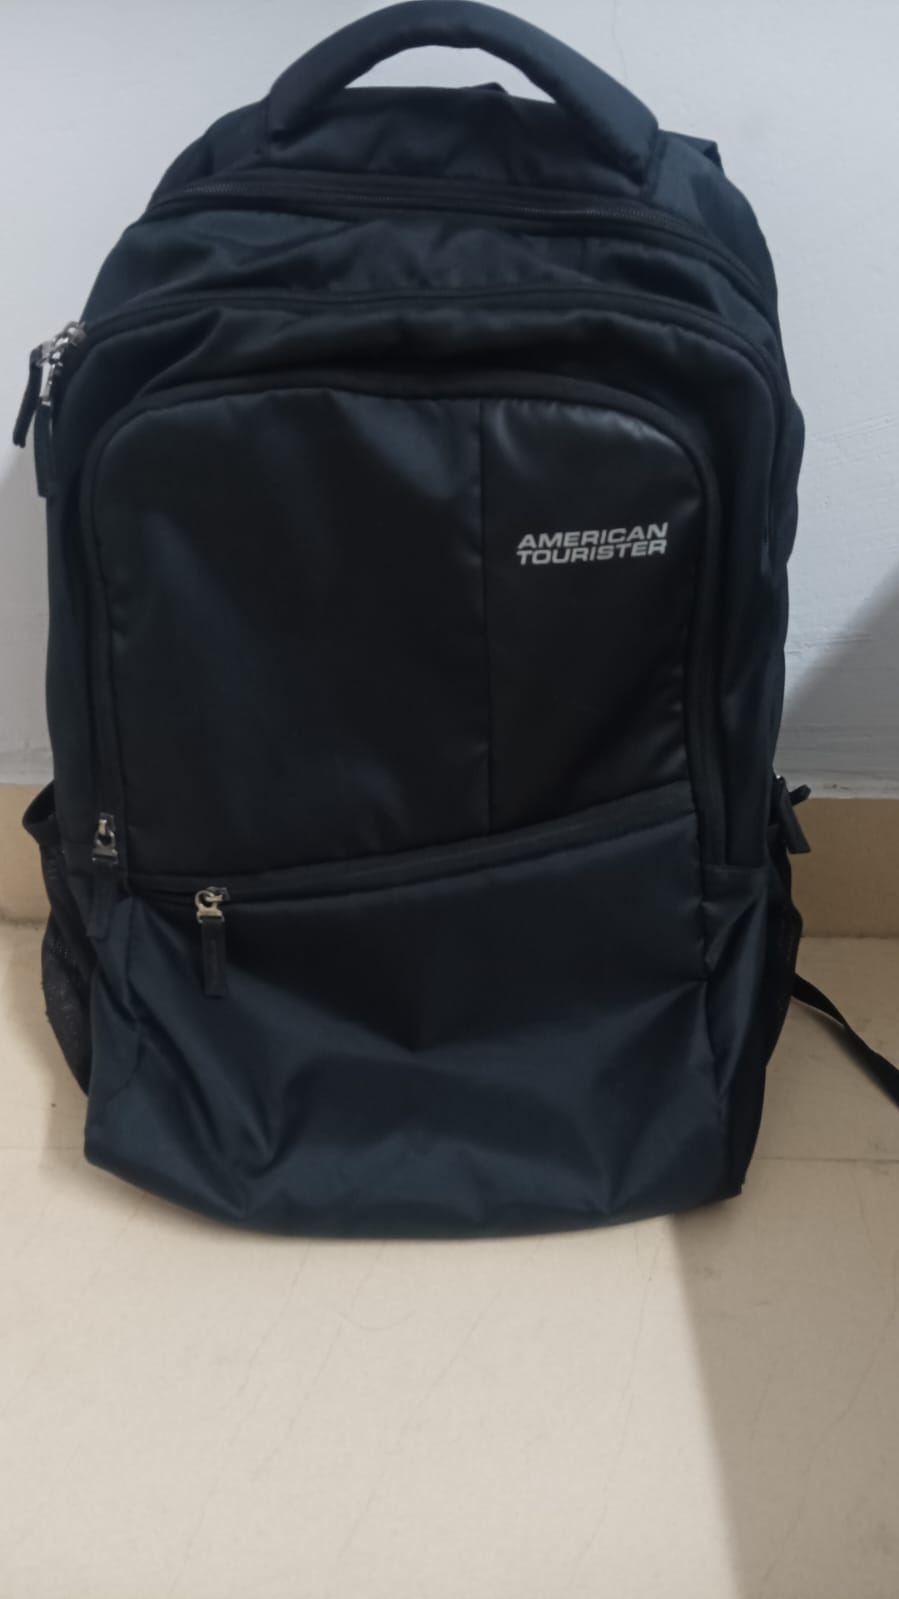

Results for BAG.jpg:
class:            backpack	probability:  99.36%
class:             mailbag	probability:   0.30%
class:         loudspeaker	probability:   0.03%
class:    bulletproof vest	probability:   0.03%
class:             holster	probability:   0.03%


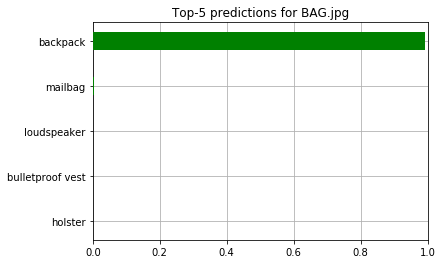

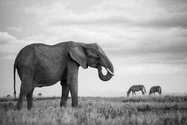

Results for HI.jpg:
class:              tusker	probability:  50.45%
class:    african elephant	probability:  23.27%
class:     indian elephant	probability:  10.49%
class:          binoculars	probability:   2.28%
class:                  ox	probability:   2.02%


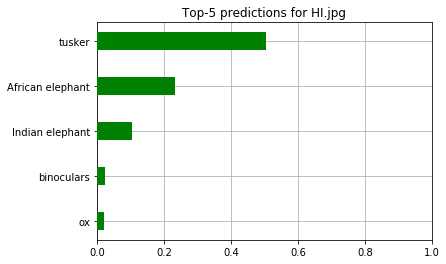

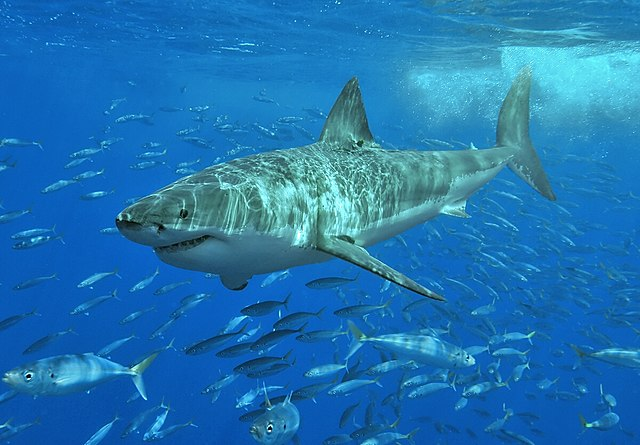

Results for 640px-White_shark.jpg:
class:   great white shark	probability:  79.40%
class:         tiger shark	probability:  18.92%
class:          hammerhead	probability:   1.63%
class:            sturgeon	probability:   0.01%
class:            stingray	probability:   0.01%


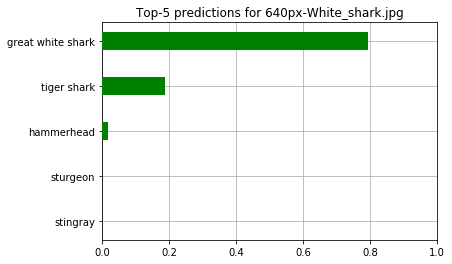

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from qnn import Dorefanet

classifier = Dorefanet()
classifier.init_accelerator()  # This is required!
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/dorefanet-layers.json")

# Assuming classifier, conv0_weights, fc_weights, names, and utils are already loaded as in your notebook

img_folder = "/home/xilinx/jupyter_notebooks/qnn/images/"
image_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_files:
    img_file = os.path.join(img_folder, img_name)
    img, img_class = classifier.load_image(img_file)
    im = Image.open(img_file)
    display(im)  # or plt.imshow(im); plt.show() if not in Jupyter

    # First convolutional layer in software
    conv0_W = conv0_weights['conv0/W']
    conv0_T = conv0_weights['conv0/T']
    conv0 = utils.conv_layer(img, conv0_W, stride=4)
    conv0 = utils.threshold(conv0, conv0_T)

    # HW offload of quantized layers
    out_dim = net['merge4']['output_dim']
    out_ch = net['merge4']['output_channels']
    conv_output = classifier.get_accel_buffer(out_ch, out_dim)
    conv_input = classifier.prepare_buffer(conv0)
    classifier.inference(conv_input, conv_output)
    conv_output = classifier.postprocess_buffer(conv_output)

    # Fully connected layers in software
    fc_input = conv_output / np.max(conv_output)
    fc0_W = fc_weights['fc0/Wn']
    fc0_b = fc_weights['fc0/bn']
    fc0_out = utils.fully_connected(fc_input, fc0_W, fc0_b)
    fc0_out = utils.qrelu(fc0_out)
    fc0_out = utils.quantize(fc0_out, 2)
    fc1_W = fc_weights['fc1/Wn']
    fc1_b = fc_weights['fc1/bn']
    fc1_out = utils.fully_connected(fc0_out, fc1_W, fc1_b)
    fc1_out = utils.qrelu(fc1_out)
    fct_W = fc_weights['fct/W']
    fct_b = np.zeros((fct_W.shape[1], ))
    fct_out = utils.fully_connected(fc1_out, fct_W, fct_b)

    # Softmax and top-5 results
    out = utils.softmax(fct_out)
    topn = utils.get_topn_indexes(out, 5)
    print(f"Results for {img_name}:")
    for k in topn:
        print("class:{0:>20}\tprobability:{1:>8.2%}".format(names[k].lower(), out[k]))
    print("="*40)

    # Optionally, plot the results
    x_pos = np.arange(len(topn))
    plt.barh(x_pos, out[topn], height=0.4, color='g', zorder=3)
    plt.yticks(x_pos, [names[k] for k in topn])
    plt.gca().invert_yaxis()
    plt.xlim([0,1])
    plt.grid(zorder=0)
    plt.title(f"Top-5 predictions for {img_name}")
    plt.show()
